## Stress Testing in Finance

Stress testing is **a risk management technique** used to evaluate how a portfolio or individual assets perform under adverse market scenarios. Instead of assuming “normal” market conditions, it simulates **extreme shocks** *(like financial crises, pandemics, interest rate spikes, currency crashes)* to estimate potential losses.

For **equities** (e.g., Nifty 50 stocks), stress testing helps:

- Identify vulnerabilities during market crashes.
- Compare portfolio resilience across asset allocation strategies.
- Guide rebalancing decisions for better downside protection.

In [ ]:
!pip install pyportfolioopt

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from pypfopt import expected_returns, risk_models, EfficientFrontier
import matplotlib.pyplot as plt


In [13]:
def stress_testing(tickers):

    data = yf.download(tickers, period="6y", auto_adjust=False)['Adj Close']
    log_returns = np.log(data/data.shift(1)).dropna()

    # Calculate expected returns and covariance matrix [cite: 44, 45, 46]
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)

    # --- Portfolio Weight Calculations ---
    # MVO Portfolio (Maximize Sharpe Ratio) [cite: 49, 50]
    ef_mvo = EfficientFrontier(mu, S)
    ef_mvo.max_sharpe()
    weights_mvo = ef_mvo.clean_weights()

    # Risk Parity Portfolio (Minimize Volatility) [cite: 52, 53]
    ef_rp = EfficientFrontier(mu, S)
    ef_rp.min_volatility()
    weights_rp = ef_rp.clean_weights()

    # Equal Weighted Portfolio [cite: 56]
    weights_ew = {ticker: 1/len(tickers) for ticker in tickers}

    print("--- Portfolio Weights (Based on 5-Year Data) ---")
    print("MVO Weights:", weights_mvo)
    print("Risk Parity Weights:", weights_rp)
    print("Equal Weighted Weights:", weights_ew)


    # Step 2: NEW - Isolate the crash period (March 2020)
    crash_log_returns = log_returns.loc['2020-01-01':'2020-05-31']

    # Step 3: NEW - Recompute performance for the crash period
    # Calculate portfolio returns for the crash period [cite: 29]
    crash_returns_mvo = (crash_log_returns @ pd.Series(weights_mvo))
    crash_returns_rp = (crash_log_returns @ pd.Series(weights_rp))
    crash_returns_ew = (crash_log_returns @ pd.Series(weights_ew))

    # Cumulative returns during the crash [cite: 167]
    crash_cumulative_mvo = np.exp(crash_returns_mvo.cumsum()) - 1
    crash_cumulative_rp = np.exp(crash_returns_rp.cumsum()) - 1
    crash_cumulative_ew = np.exp(crash_returns_ew.cumsum()) - 1

    # Performance Metrics for the crash period
    # Total Return (for March 2020) [cite: 31]
    total_return_crash_mvo = crash_cumulative_mvo.iloc[-1]
    total_return_crash_rp = crash_cumulative_rp.iloc[-1]
    total_return_crash_ew = crash_cumulative_ew.iloc[-1]

    # Volatility (Standard deviation of daily returns) [cite: 33]
    volatility_crash_mvo = crash_returns_mvo.std()
    volatility_crash_rp = crash_returns_rp.std()
    volatility_crash_ew = crash_returns_ew.std()

    # Annualized figures are less meaningful for a single month, but we show them for consistency
    # Note: Multiplying daily volatility by sqrt(252) for annualization
    annualized_volatility_mvo = volatility_crash_mvo * np.sqrt(252)
    annualized_volatility_rp = volatility_crash_rp * np.sqrt(252)
    annualized_volatility_ew = volatility_crash_ew * np.sqrt(252)

    # Display results
    print("\n--- Performance During March 2020 Crash ---")
    print(f"\nMean-Variance Optimization (MVO) Portfolio:")
    print(f" Total Return: {total_return_crash_mvo:.2%}")
    print(f" Daily Volatility: {volatility_crash_mvo:.2%}")
    print(f" Annualized Volatility: {annualized_volatility_mvo:.2%}")

    print(f"\nRisk Parity (Inverse Volatility) Portfolio:")
    print(f" Total Return: {total_return_crash_rp:.2%}")
    print(f" Daily Volatility: {volatility_crash_rp:.2%}")
    print(f" Annualized Volatility: {annualized_volatility_rp:.2%}")

    print(f"\nEqual Weighted Portfolio:")
    print(f" Total Return: {total_return_crash_ew:.2%}")
    print(f" Daily Volatility: {volatility_crash_ew:.2%}")
    print(f" Annualized Volatility: {annualized_volatility_ew:.2%}")

    # Step 4: NEW - Plotting the results for the crash period
    plt.figure(figsize=(12, 7))
    plt.plot(crash_cumulative_mvo, label="MVO Portfolio", linewidth=2)
    plt.plot(crash_cumulative_rp, label="Risk Parity Portfolio", linewidth=2)
    plt.plot(crash_cumulative_ew, label="Equal Weighted Portfolio", linewidth=2)
    plt.title('Portfolio Performance During March 2020 Crash')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()



This is not a true historical backtest (since are using data that wasn’t available before the crisis), but it’s a very useful forward-looking scenario analysis for today’s portfolio.

[*********************100%***********************]  5 of 5 completed


--- Portfolio Weights (Based on 5-Year Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 0.07755, 'INFY.NS': 0.21048, 'ITC.NS': 0.37048, 'RELIANCE.NS': 0.34148, 'TCS.NS': 0.0})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.22529, 'INFY.NS': 0.05395, 'ITC.NS': 0.31648, 'RELIANCE.NS': 0.09429, 'TCS.NS': 0.30999})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

--- Performance During March 2020 Crash ---

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: -10.29%
 Daily Volatility: 2.91%
 Annualized Volatility: 46.25%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: -14.30%
 Daily Volatility: 2.66%
 Annualized Volatility: 42.27%

Equal Weighted Portfolio:
 Total Return: -11.75%
 Daily Volatility: 2.76%
 Annualized Volatility: 43.83%


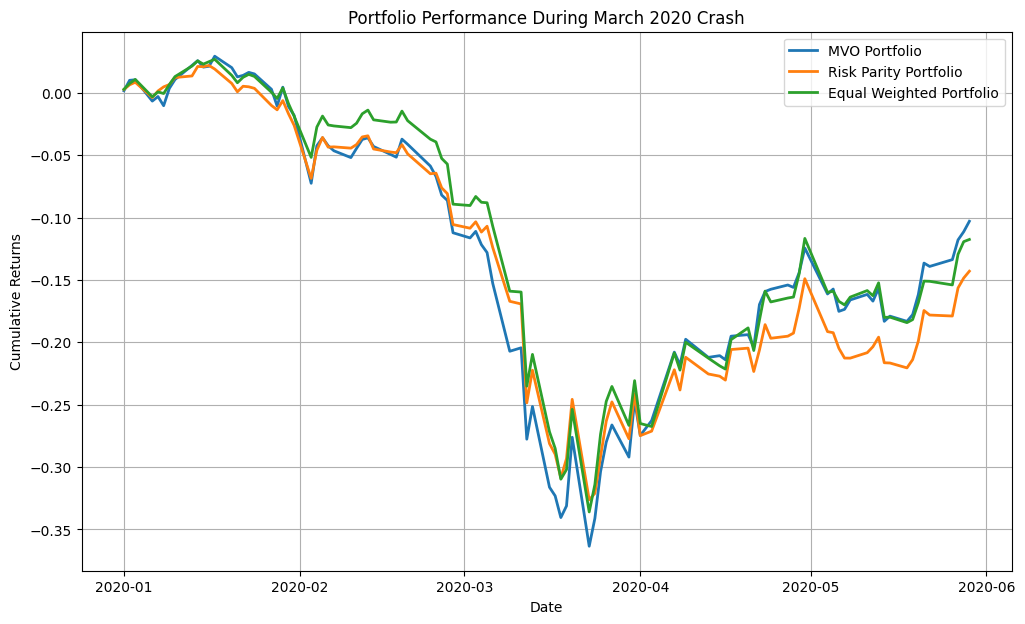

In [6]:

# Step 1: Download historical data and calculate weights (as in the document)
tickers = ['RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'TCS.NS', 'ITC.NS']

stress_testing(tickers)

#### Changing the data only to use the returns upto the stress test start date so that the Crisis will actually will be like a shock period, which was not anticipated. The returns for the period will be obvious hugely negative.

Calculate Weights at the Start of Each Stress Period:

Will use only data up to the stress start date (e.g., for 2008 GFC, data until Dec 2007). Compute weights from that pre-crisis info. Then apply those weights to the stress window.

**Main Approach**
Recalculate Weights for Each Stress Period (Historical Look-Back)

Run the optimization (MVO, risk parity, EW) as if were an investor at the start of each stress period.

Weights are based only on information available before the crisis (historical vol, correlations, expected returns).

Then simulate how that portfolio would have performed during the stress window.

✅ Pros: More realistic for historical backtesting. Shows how a strategy would have worked in real time.

❌ Cons: Computationally heavier. Sensitive to estimation windows.

In [64]:

def stress_test_dp(tickers, datastart="2019-01-01", dataend="2025-01-01",stressstart="2022-05-01", stressend="2022-10-31", period_name="Performance During March 2020 Crash"):

  # Step 1: Download historical data with a fixed date range

  # CORRECTED LINE: Using start and end dates to include March 2020
  data_OP = yf.download(tickers, start=datastart, end=stressstart, auto_adjust=False)['Adj Close']

  data_stress = yf.download(tickers, start=stressstart, end=stressend, auto_adjust=False)['Adj Close']

  log_returns = np.log(data_OP/data_OP.shift(1)).dropna()

  # Calculate expected returns and covariance matrix
  # Note: For consistency, we use the full dataset for weight calculation as before
  mu = expected_returns.mean_historical_return(data_OP)
  S = risk_models.sample_cov(data_OP)

  # --- Portfolio Weight Calculations ---
  # MVO Portfolio (Maximize Sharpe Ratio)
  ef_mvo = EfficientFrontier(mu, S)
  ef_mvo.max_sharpe()
  weights_mvo = ef_mvo.clean_weights()

  # Risk Parity Portfolio (Minimize Volatility)
  ef_rp = EfficientFrontier(mu, S)
  ef_rp.min_volatility()
  weights_rp = ef_rp.clean_weights()

  # Equal Weighted Portfolio
  weights_ew = {ticker: 1/len(tickers) for ticker in tickers}

  print("--- Portfolio Weights (Based on Full Data) ---")
  print("MVO Weights:", weights_mvo)
  print("Risk Parity Weights:", weights_rp)
  print("Equal Weighted Weights:", weights_ew)

  # Step 2: Isolate the crash period (eg. March 2020)
  crash_log_returns = np.log(data_stress/data_stress.shift(1)).dropna()

  # ADDED CHECK: Ensure the crash data is not empty before proceeding
  if crash_log_returns.empty:
      print("\nError: No data available for Stress period in the downloaded date range.")
  else:
      # Step 3: Recompute performance for the crash period
      crash_returns_mvo = (crash_log_returns @ pd.Series(weights_mvo))
      crash_returns_rp = (crash_log_returns @ pd.Series(weights_rp))
      crash_returns_ew = (crash_log_returns @ pd.Series(weights_ew))

      # Cumulative returns during the crash
      crash_cumulative_mvo = np.exp(crash_returns_mvo.cumsum()) - 1
      crash_cumulative_rp = np.exp(crash_returns_rp.cumsum()) - 1
      crash_cumulative_ew = np.exp(crash_returns_ew.cumsum()) - 1

      # Performance Metrics for the crash period
      total_return_crash_mvo = crash_cumulative_mvo.iloc[-1]
      total_return_crash_rp = crash_cumulative_rp.iloc[-1]
      total_return_crash_ew = crash_cumulative_ew.iloc[-1]

      # Volatility (Standard deviation of daily returns)
      volatility_crash_mvo = crash_returns_mvo.std()
      volatility_crash_rp = crash_returns_rp.std()
      volatility_crash_ew = crash_returns_ew.std()

      annualized_volatility_mvo = volatility_crash_mvo * np.sqrt(252)
      annualized_volatility_rp = volatility_crash_rp * np.sqrt(252)
      annualized_volatility_ew = volatility_crash_ew * np.sqrt(252)

      # Display results
      print("\n" + period_name)
      print(f"\nMean-Variance Optimization (MVO) Portfolio:")
      print(f" Total Return: {total_return_crash_mvo:.2%}")
      print(f" Daily Volatility: {volatility_crash_mvo:.2%}")
      print(f" Annualized Volatility: {annualized_volatility_mvo:.2%}")

      print(f"\nRisk Parity (Inverse Volatility) Portfolio:")
      print(f" Total Return: {total_return_crash_rp:.2%}")
      print(f" Daily Volatility: {volatility_crash_rp:.2%}")
      print(f" Annualized Volatility: {annualized_volatility_rp:.2%}")

      print(f"\nEqual Weighted Portfolio:")
      print(f" Total Return: {total_return_crash_ew:.2%}")
      print(f" Daily Volatility: {volatility_crash_ew:.2%}")
      print(f" Annualized Volatility: {annualized_volatility_ew:.2%}")

      # Step 4: Plotting the results for the crash period
      plt.figure(figsize=(12, 7))
      plt.plot(crash_cumulative_mvo, label="MVO Portfolio", linewidth=2)
      plt.plot(crash_cumulative_rp, label="Risk Parity Portfolio", linewidth=2)
      plt.plot(crash_cumulative_ew, label="Equal Weighted Portfolio", linewidth=2)
      plt.title(period_name)
      plt.xlabel('Date')
      plt.ylabel('Cumulative Returns')
      plt.legend()
      plt.grid(True)
      plt.show()


def calculate_drawdown(ticker, data_start, data_end, stress_start, stress_end):
    """
    Pulls price data from Yahoo Finance and calculates drawdown
    for the specified stress period.
    """
    try:
      # Download data
      data = yf.download(ticker, start=data_start, end=data_end, auto_adjust=False, progress=False)
      data = data["Adj Close"]

      # Slice stress period
      stress_data = data.loc[stress_start:stress_end]

      if stress_data.empty:
          return None, None, None

      # Calculate peak, trough, and drawdown
      peak = float(stress_data.max().iloc[0])
      trough = float(stress_data.min().iloc[0])
      drawdown = (trough - peak) / peak * 100  # percentage

      return peak, trough, drawdown
    except Exception as e:
        print(f"Error for period {stress_start} to {stress_end}: {e}")
        return None, None, None

#### Testing the same for the full set of index tickers

[*********************100%***********************]  46 of 46 completed
[*********************100%***********************]  46 of 46 completed


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'ADANIENT.NS': 0.0, 'ADANIPORTS.NS': 0.0, 'APOLLOHOSP.NS': 0.0, 'ASIANPAINT.NS': 0.0, 'AXISBANK.NS': 0.0, 'BAJAJ-AUTO.NS': 0.0, 'BAJAJFINSV.NS': 0.04732, 'BAJFINANCE.NS': 0.14629, 'BEL.NS': 0.0, 'BHARTIARTL.NS': 0.0, 'BRITANNIA.NS': 0.0, 'COALINDIA.NS': 0.0, 'DIVISLAB.NS': 0.0, 'DRREDDY.NS': 0.0, 'EICHERMOT.NS': 0.0, 'GRASIM.NS': 0.0, 'HCLTECH.NS': 0.0, 'HDFCBANK.NS': 0.16216, 'HDFCLIFE.NS': 0.083, 'HINDALCO.NS': 0.0, 'HINDUNILVR.NS': 0.07909, 'ICICIBANK.NS': 0.0, 'INDUSINDBK.NS': 0.0, 'INFY.NS': 0.0, 'ITC.NS': 0.0, 'JSWSTEEL.NS': 0.0, 'KOTAKBANK.NS': 0.0, 'LT.NS': 0.0, 'LTIM.NS': 0.12899, 'M&M.NS': 0.0, 'MARUTI.NS': 0.0, 'NESTLEIND.NS': 0.11649, 'NTPC.NS': 0.0, 'ONGC.NS': 0.0, 'POWERGRID.NS': 0.0, 'RELIANCE.NS': 0.11052, 'SBIN.NS': 0.0, 'SHREECEM.NS': 0.0, 'SUNPHARMA.NS': 0.0, 'TATAMOTORS.NS': 0.0, 'TATASTEEL.NS': 0.0, 'TCS.NS': 0.08452, 'TECHM.NS': 0.0, 'TITAN.NS': 0.04161, 'ULTRACEMCO.NS': 0.0, 'WIPRO.NS': 0.0}

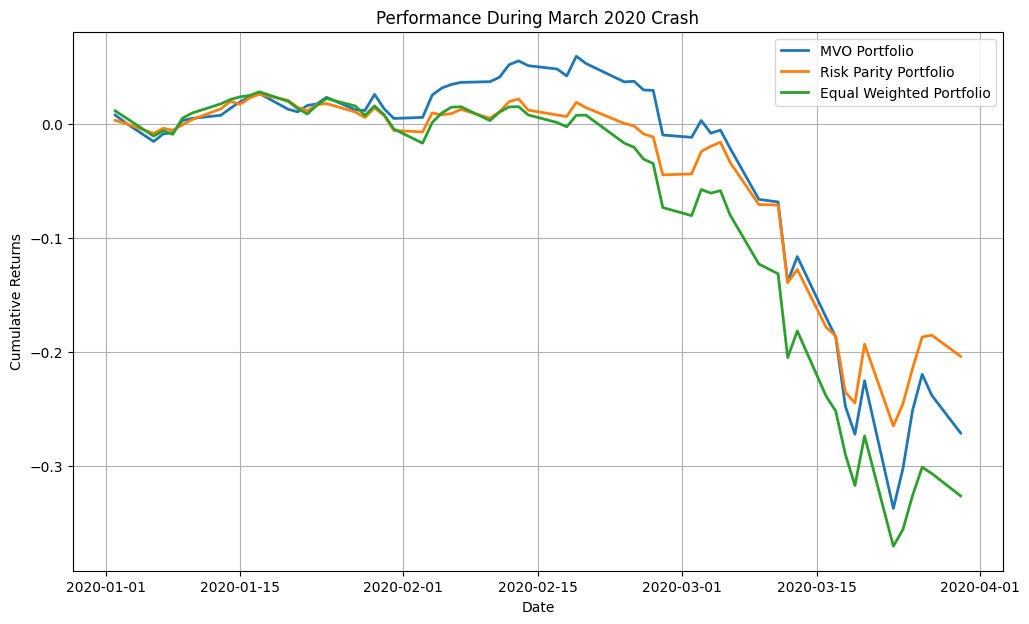

In [65]:
nifty50_tickers = [
    "ADANIENT.NS",
    "ADANIPORTS.NS",
    "APOLLOHOSP.NS",
    "ASIANPAINT.NS",
    "AXISBANK.NS",
    "BAJAJ-AUTO.NS",
    "BAJFINANCE.NS",
    "BAJAJFINSV.NS",
    "BEL.NS",
    "BHARTIARTL.NS",
    "BRITANNIA.NS",
    "COALINDIA.NS",
    "DIVISLAB.NS",
    "DRREDDY.NS",
    "EICHERMOT.NS",
    "GRASIM.NS",
    "HCLTECH.NS",
    "HDFCBANK.NS",
    "HDFCLIFE.NS",
    "HINDALCO.NS",
    "HINDUNILVR.NS",
    "ICICIBANK.NS",
    "INDUSINDBK.NS",
    "INFY.NS",
    "ITC.NS",
    "JSWSTEEL.NS",
    "KOTAKBANK.NS",
    "LT.NS",
    "LTIM.NS",
    "M&M.NS",
    "MARUTI.NS",
    "NESTLEIND.NS",
    "NTPC.NS",
    "ONGC.NS",
    "POWERGRID.NS",
    "RELIANCE.NS",
    "SBIN.NS",
    "SHREECEM.NS",
    "SUNPHARMA.NS",
    "TATAMOTORS.NS",
    "TATASTEEL.NS",
    "TCS.NS",
    "TECHM.NS",
    "TITAN.NS",
    "ULTRACEMCO.NS",
    "WIPRO.NS"
]


stress_test_dp(nifty50_tickers, datastart= "2016-01-01", stressstart="2020-01-01", stressend="2020-03-31")

Analysis of Allocation Robustness 💪
Risk Parity (Most Robust): The Risk Parity portfolio demonstrated the most resilience, with the lowest total loss -20.37% and the lowest volatility. By design, this strategy minimizes portfolio volatility by giving higher weights to less volatile assets. This inherent focus on risk management provides a significant defensive cushion during a market-wide panic, proving its robustness.



Mean-Variance Optimization (Least Robust): The MVO portfolio, which was optimized to maximize the Sharpe ratio over a 5-year period, performed the worst during the crash, falling by -27.10%. This is because MVO often creates more concentrated portfolios, allocating heavily to assets with the best historical risk-adjusted returns. When a systemic shock hits the market, this concentration can lead to larger losses if those specific assets are hit hard.


Equal Weighted (Simple but Effective Diversification): The Equal Weighted portfolio which generally provides a middle ground. This strategy's strength is its simplicity and inherent diversification; it avoids concentrating capital in a few high-performing assets, which helps mitigate losses during a downturn compared to the MVO strategy.


In conclusion, while MVO is a powerful strategy for maximizing long-term returns , the

Risk Parity strategy is superior for capital preservation during a market crash. This simulation clearly illustrates the trade-off between optimizing for returns and building a portfolio that is robust enough to withstand severe market stress.

### Further testing for 7 major stress periods covering both global shocks and India-specific ones

Pulls a couple of years of data before & after the stress window, so to compute:

- Pre-crisis baseline
- Crisis drawdown
- Post-crisis recovery

Since index constituents are dynamic, picking a subset of tickers which presisted throughout the 7 major stress periods for making the analysis, the results will wary when the total index constituents are selected.

📉 Major Crisis Periods (India & Global)

Global Financial Crisis (2008)
- Period: Jan 2008 – Mar 2009
- Nifty fell from peak to trough.
- Trigger: Lehman collapse, global credit freeze.

Taper Tantrum (2013)
- Period: May 2013 – Sep 2013
- Nifty fell ~15–20%.
- Trigger: US Fed hinting QE tapering → FII outflows → INR depreciation.

Demonetization (2016)
- Period: Nov 2016 – Jan 2017
- Short but sharp ~7–10% dip.
- Trigger: Overnight ban of ₹500/₹1000 notes.

IL&FS & NBFC Liquidity Crisis (2018)

- Period: Sep 2018 – Oct 2018
- Nifty Midcap/Smallcap hit harder than large caps.
- Trigger: IL&FS default → NBFC sector stress.

COVID-19 Crash (2020)

- Period: Feb 2020 – Mar 2020
- Nifty fell ~30% in ~6 weeks.
- Trigger: Pandemic, global lockdowns.

Russia-Ukraine War & Inflation Spike (2022)
- Period: Jan 2022 – Jun 2022
- Nifty corrected ~15–17%.
- Trigger: War, crude oil spike, global inflation, rate hikes.

In [27]:
stress_periods = {
    "Global Financial Crisis 2008": {
        "data_start": "2007-01-01",
        "data_end": "2009-12-31",
        "stress_start": "2008-01-01",
        "stress_end": "2009-03-31"
    },
    "Taper Tantrum 2013": {
        "data_start": "2012-01-01",
        "data_end": "2014-12-31",
        "stress_start": "2013-05-01",
        "stress_end": "2013-09-30"
    },
    "COVID-19 Crash 2020": {
        "data_start": "2019-01-01",
        "data_end": "2021-12-31",
        "stress_start": "2020-02-01",
        "stress_end": "2020-03-31"
    },
    "Russia-Ukraine War 2022": {
        "data_start": "2021-01-01",
        "data_end": "2023-12-31",
        "stress_start": "2022-01-01",
        "stress_end": "2022-06-30"
    },
    "India Elections Shock 2004": {
        "data_start": "2003-01-01",
        "data_end": "2005-12-31",
        "stress_start": "2004-05-10",
        "stress_end": "2004-05-31"
    },
    "Demonetization 2016": {
        "data_start": "2015-01-01",
        "data_end": "2017-12-31",
        "stress_start": "2016-11-08",
        "stress_end": "2017-01-31"
    },
    "ILFS Liquidity Crisis 2018": {
        "data_start": "2017-01-01",
        "data_end": "2019-12-31",
        "stress_start": "2018-09-01",
        "stress_end": "2018-10-31"
    }
}



stress_data_period: 2007-01-01 : 2009-12-31   stress_test_period 2008-01-01:2009-03-31

Stress Period: 2008-01-01 to 2009-03-31
NiftyPeak: 6287.85, Nifty Trough: 2524.20
Nifty Drawdown: -59.86%
++++++++++++++++++++++++++++++++++++++++



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 0.0, 'INFY.NS': 0.0, 'ITC.NS': 0.0, 'RELIANCE.NS': 1.0, 'TCS.NS': 0.0})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.04573, 'INFY.NS': 0.22713, 'ITC.NS': 0.35376, 'RELIANCE.NS': 0.12809, 'TCS.NS': 0.24528})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

Global Financial Crisis 2008

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: -46.48%
 Daily Volatility: 3.86%
 Annualized Volatility: 61.28%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: -32.73%
 Daily Volatility: 2.45%
 Annualized Volatility: 38.93%

Equal Weighted Portfolio:
 Total Return: -37.38%
 Daily Volatility: 2.59%
 Annualized Volatility: 41.06%


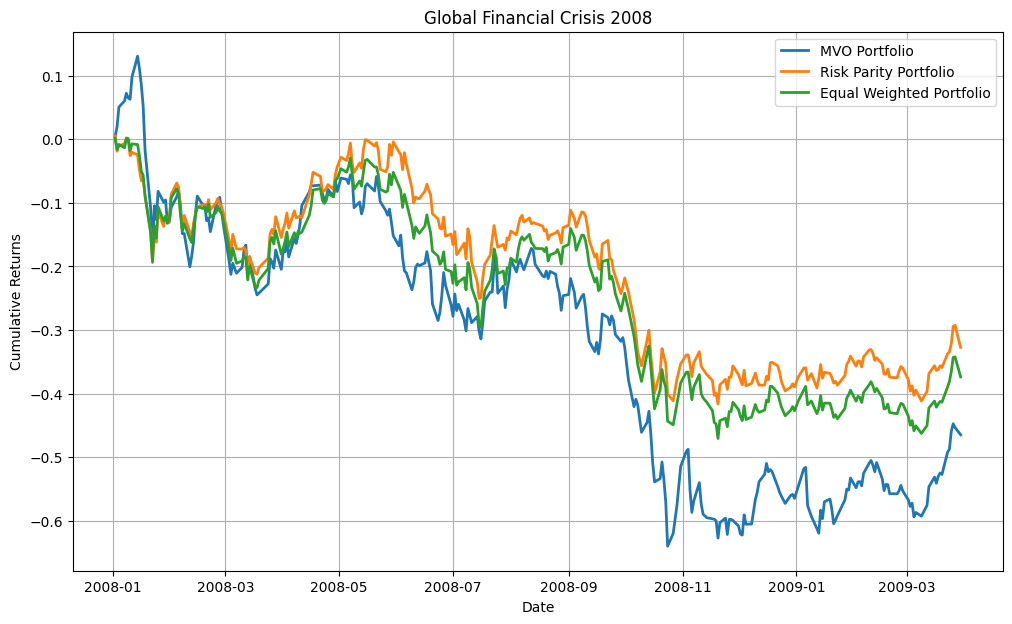


stress_data_period: 2012-01-01 : 2014-12-31   stress_test_period 2013-05-01:2013-09-30

Stress Period: 2013-05-01 to 2013-09-30
NiftyPeak: 6187.30, Nifty Trough: 5285.00
Nifty Drawdown: -14.58%
++++++++++++++++++++++++++++++++++++++++



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 0.48499, 'INFY.NS': 0.0, 'ITC.NS': 0.50339, 'RELIANCE.NS': 0.0, 'TCS.NS': 0.01162})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.19934, 'INFY.NS': 0.09161, 'ITC.NS': 0.32678, 'RELIANCE.NS': 0.21224, 'TCS.NS': 0.17003})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

Taper Tantrum 2013

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: -2.56%
 Daily Volatility: 1.86%
 Annualized Volatility: 29.50%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: 9.08%
 Daily Volatility: 1.46%
 Annualized Volatility: 23.16%

Equal Weighted Portfolio:
 Total Return: 12.67%
 Daily Volatility: 1.35%
 Annualized Volatility: 21.51%


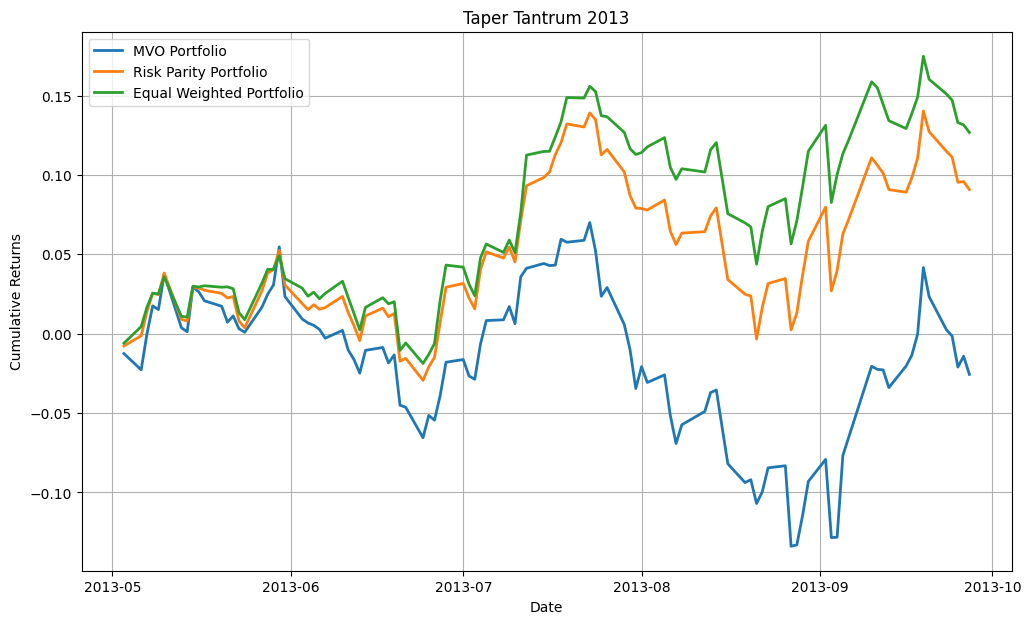


stress_data_period: 2019-01-01 : 2021-12-31   stress_test_period 2020-02-01:2020-03-31

Stress Period: 2020-02-01 to 2020-03-31
NiftyPeak: 12201.20, Nifty Trough: 7610.25
Nifty Drawdown: -37.63%
++++++++++++++++++++++++++++++++++++++++



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 0.32659, 'INFY.NS': 0.24559, 'ITC.NS': 0.0, 'RELIANCE.NS': 0.31454, 'TCS.NS': 0.11327})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.26024, 'INFY.NS': 0.14887, 'ITC.NS': 0.24906, 'RELIANCE.NS': 0.11605, 'TCS.NS': 0.22577})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

COVID-19 Crash 2020

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: -24.33%
 Daily Volatility: 3.93%
 Annualized Volatility: 62.38%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: -22.94%
 Daily Volatility: 3.54%
 Annualized Volatility: 56.27%

Equal Weighted Portfolio:
 Total Return: -22.66%
 Daily Volatility: 3.64%
 Annualized Volatility: 57.84%


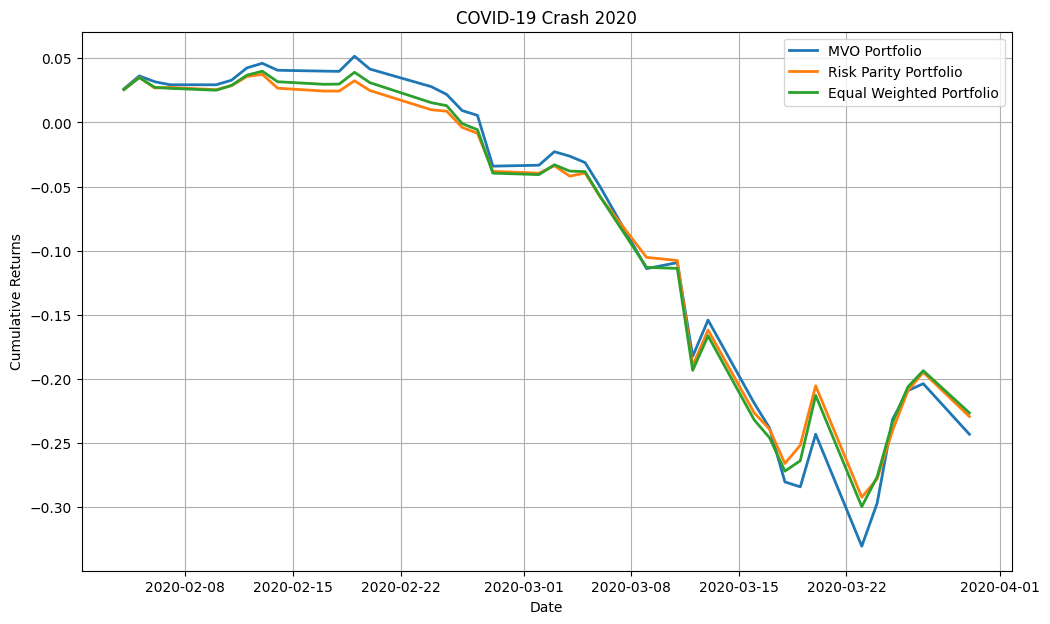


stress_data_period: 2021-01-01 : 2023-12-31   stress_test_period 2022-01-01:2022-06-30

Stress Period: 2022-01-01 to 2022-06-30
NiftyPeak: 18308.10, Nifty Trough: 15293.50
Nifty Drawdown: -16.47%
++++++++++++++++++++++++++++++++++++++++



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 0.0, 'INFY.NS': 0.99233, 'ITC.NS': 0.0, 'RELIANCE.NS': 0.00767, 'TCS.NS': 0.0})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.21628, 'INFY.NS': 0.22301, 'ITC.NS': 0.19287, 'RELIANCE.NS': 0.09306, 'TCS.NS': 0.27478})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

Russia-Ukraine War 2022

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: -21.92%
 Daily Volatility: 1.91%
 Annualized Volatility: 30.35%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: -5.79%
 Daily Volatility: 1.32%
 Annualized Volatility: 20.90%

Equal Weighted Portfolio:
 Total Return: -3.16%
 Daily Volatility: 1.30%
 Annualized Volatility: 20.65%


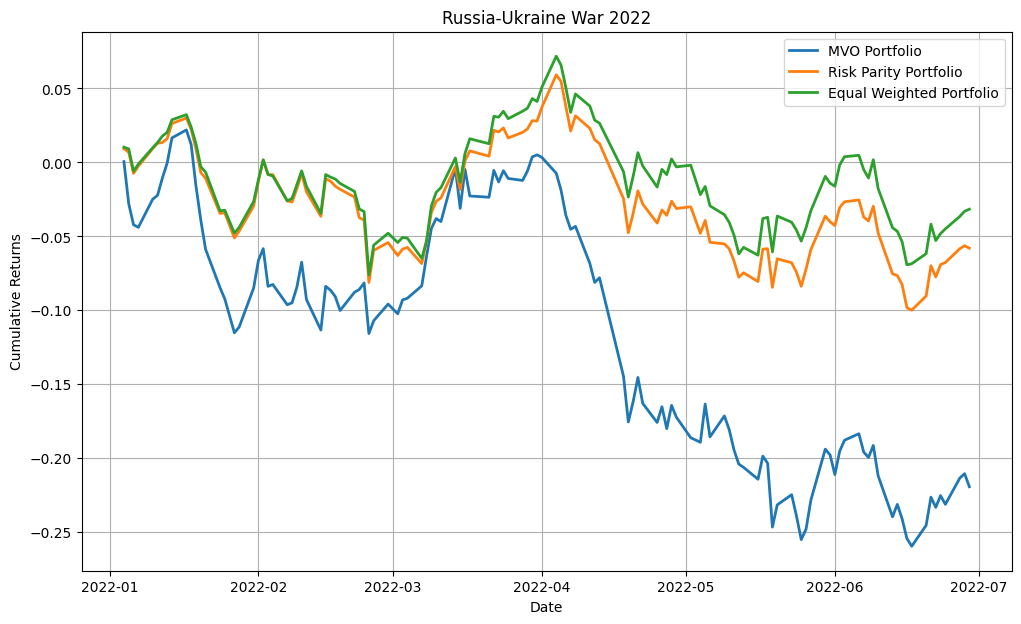

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2003-01-01 -> 2005-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1041359400, endDate = 1135967400")')



stress_data_period: 2003-01-01 : 2005-12-31   stress_test_period 2004-05-10:2004-05-31



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
/usr/local/lib/python3.12/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 0.27441, 'INFY.NS': 0.0, 'ITC.NS': 0.27123, 'RELIANCE.NS': 0.44723, 'TCS.NS': 0.00713})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.28163, 'INFY.NS': 0.07719, 'ITC.NS': 0.43134, 'RELIANCE.NS': 0.20097, 'TCS.NS': 0.00886})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

India Elections Shock 2004

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: -11.16%
 Daily Volatility: 6.15%
 Annualized Volatility: 97.59%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: -9.54%
 Daily Volatility: 5.92%
 Annualized Volatility: 93.97%

Equal Weighted Portfolio:
 Total Return: -11.72%
 Daily Volatility: 5.90%
 Annualized Volatility: 93.60%


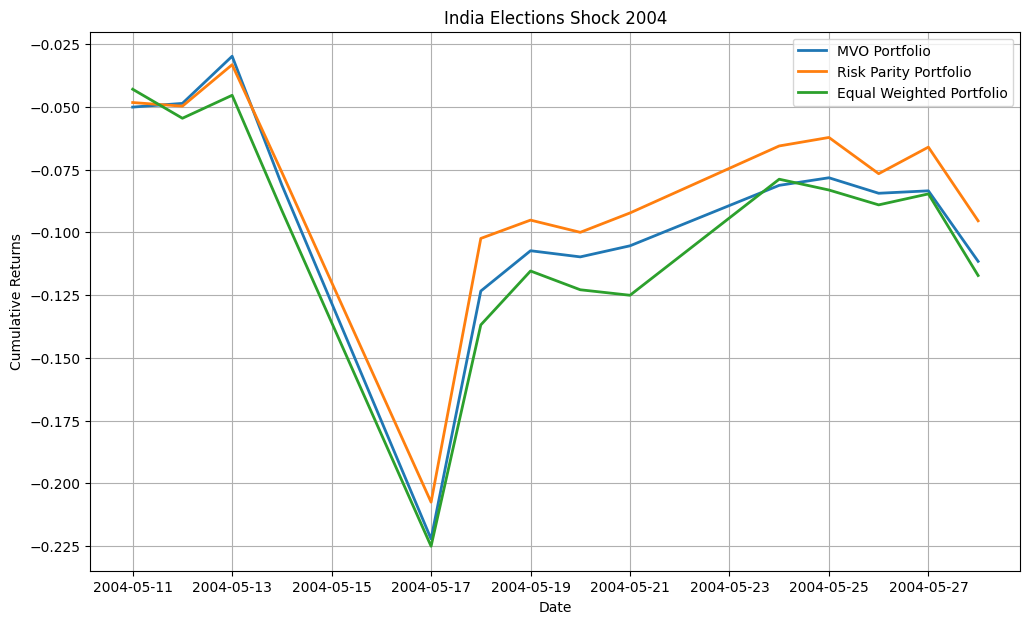


stress_data_period: 2015-01-01 : 2017-12-31   stress_test_period 2016-11-08:2017-01-31

Stress Period: 2016-11-08 to 2017-01-31
NiftyPeak: 8641.25, Nifty Trough: 7908.25
Nifty Drawdown: -8.48%
++++++++++++++++++++++++++++++++++++++++



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 1.0, 'INFY.NS': 0.0, 'ITC.NS': 0.0, 'RELIANCE.NS': 0.0, 'TCS.NS': 0.0})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.46071, 'INFY.NS': 0.11862, 'ITC.NS': 0.13131, 'RELIANCE.NS': 0.0482, 'TCS.NS': 0.24115})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

Demonetization 2016

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: 2.44%
 Daily Volatility: 0.98%
 Annualized Volatility: 15.53%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: 1.52%
 Daily Volatility: 0.88%
 Annualized Volatility: 13.91%

Equal Weighted Portfolio:
 Total Return: 1.13%
 Daily Volatility: 0.86%
 Annualized Volatility: 13.63%


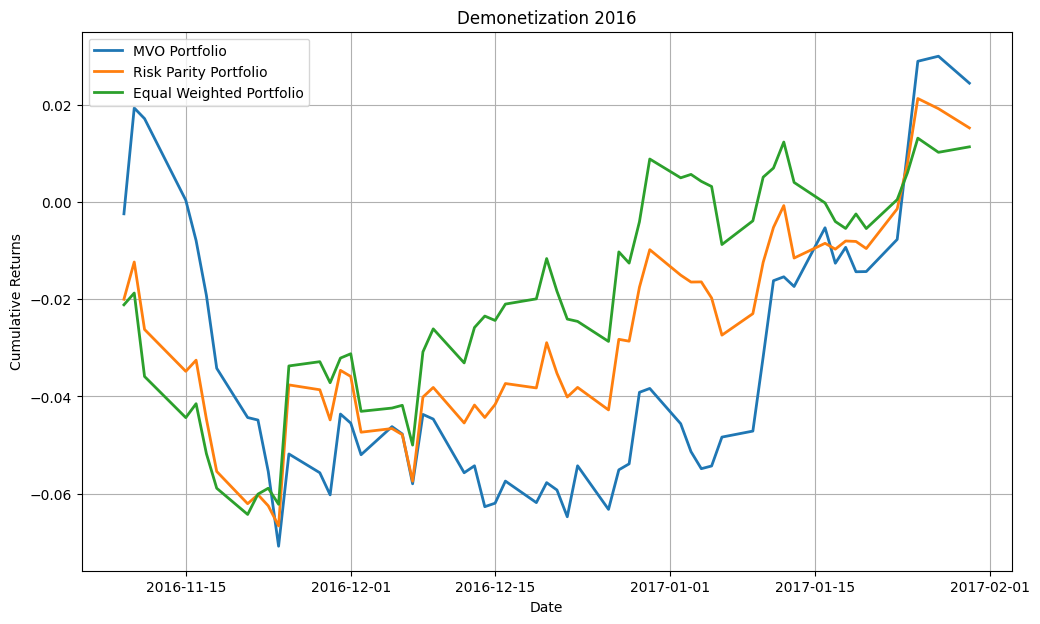


stress_data_period: 2017-01-01 : 2019-12-31   stress_test_period 2018-09-01:2018-10-31

Stress Period: 2018-09-01 to 2018-10-31
NiftyPeak: 11589.10, Nifty Trough: 10030.00
Nifty Drawdown: -13.45%
++++++++++++++++++++++++++++++++++++++++



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


--- Portfolio Weights (Based on Full Data) ---
MVO Weights: OrderedDict({'HDFCBANK.NS': 0.38834, 'INFY.NS': 0.06683, 'ITC.NS': 0.05662, 'RELIANCE.NS': 0.27049, 'TCS.NS': 0.21771})
Risk Parity Weights: OrderedDict({'HDFCBANK.NS': 0.39994, 'INFY.NS': 0.15025, 'ITC.NS': 0.1506, 'RELIANCE.NS': 0.14475, 'TCS.NS': 0.15445})
Equal Weighted Weights: {'RELIANCE.NS': 0.2, 'HDFCBANK.NS': 0.2, 'INFY.NS': 0.2, 'TCS.NS': 0.2, 'ITC.NS': 0.2}

ILFS Liquidity Crisis 2018

Mean-Variance Optimization (MVO) Portfolio:
 Total Return: -9.59%
 Daily Volatility: 1.23%
 Annualized Volatility: 19.46%

Risk Parity (Inverse Volatility) Portfolio:
 Total Return: -9.05%
 Daily Volatility: 1.12%
 Annualized Volatility: 17.81%

Equal Weighted Portfolio:
 Total Return: -9.50%
 Daily Volatility: 1.23%
 Annualized Volatility: 19.52%


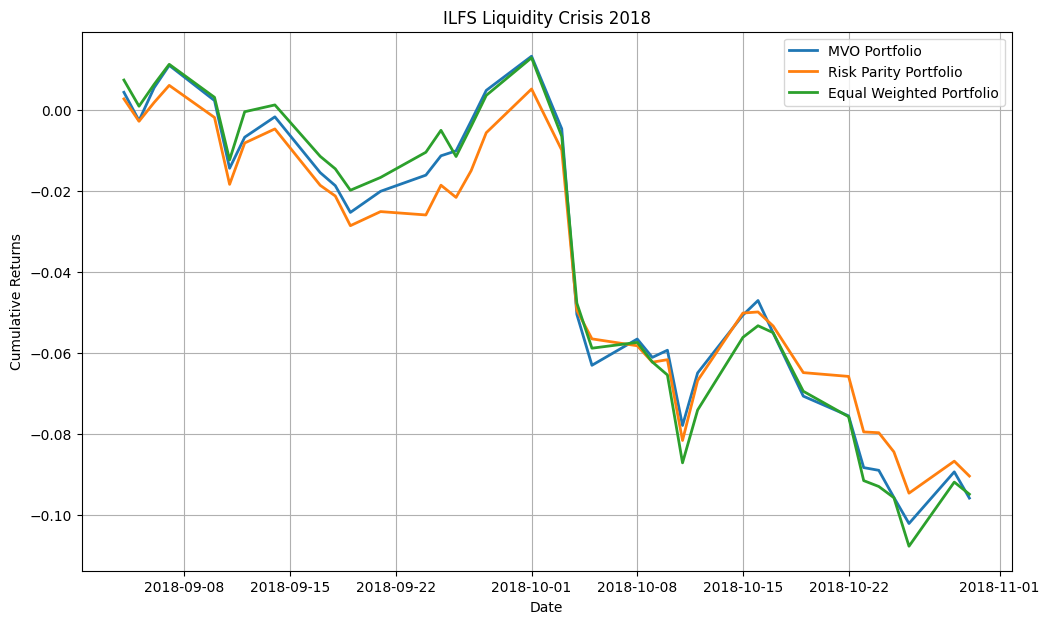

In [66]:
for key in stress_periods.keys():

  datastart = stress_periods[key]['data_start']
  dataend = stress_periods[key]['data_end']
  stressstart = stress_periods[key]['stress_start']
  stressend = stress_periods[key]['stress_end']
  print("\nstress_data_period: " + datastart + " : " + dataend + "   stress_test_period " + stressstart + ":" + stressend + "\n")

  peak, trough, drawdown = calculate_drawdown("^NSEI", datastart, dataend, stressstart, stressend)

  if peak != None:
    print(f"Stress Period: {stressstart} to {stressend}")
    print(f"NiftyPeak: {peak:.2f}, Nifty Trough: {trough:.2f}")
    print(f"Nifty Drawdown: {drawdown:.2f}%")
    print("+"*40 + "\n")

  stress_test_dp(tickers, datastart=datastart, dataend=dataend,stressstart=stressstart, stressend=stressend,period_name=key)

Next steps, the same can be run by pulling the tickers of the index as of that period data start date, and run the stress test which will show with clarity which portfolio approach performs better. Similar to the initial Covid crash analysis, the subset of index tickers showed MVO performed better, however when the same was performed for the full set of index tickers the **Risk parity approach came out as a clear winner** except for the demonetization period which was purely Indian monetary policy(unconventional) event.